In [2]:
#pip install -qqq bitsandbytes torch transformers peft accelerate datasets loralib einops trl evaluate matplotlib tensorboard rouge_score bert_score

from transformers import AutoModelForSeq2SeqLM
import torch
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import evaluate
from transformers import AutoModelForSeq2SeqLM
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import matplotlib.pyplot as plt
from transformers import DataCollatorForLanguageModeling
from datasets import load_dataset
from datasets import DatasetDict
import os
from utils import prepare_prompt



/users/eleves-b/2022/ayoub.melliti/LLM project/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
max_length = 2500

IDEE A DEV:
-lire papiers de recherches
-Tester modele encodeur decodeur

# Dataset Splitting

In [4]:
dataset_raw = load_dataset('json', data_files='dataset_llm_generated.json')



In [5]:
dataset = dataset_raw.select_columns(["text", "summary"])

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 5000
    })
})


Text(0.5, 1.0, 'Distibution')

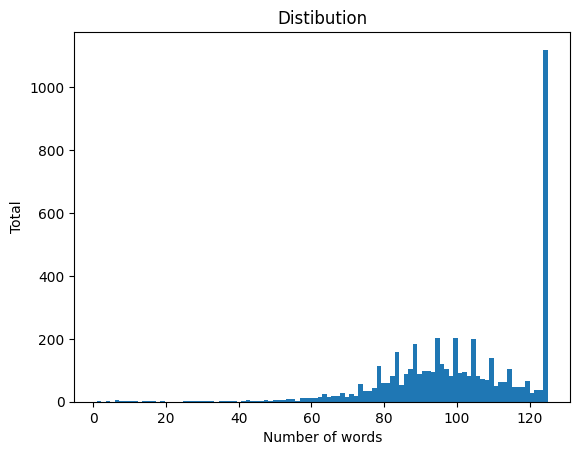

In [6]:
def get_num_word(example):
    return {"num_word": len(example["summary"].split())}

dataset_num_word = dataset['train'].map(get_num_word)

plt.hist(dataset_num_word["num_word"], bins=100)
plt.xlabel("Number of words")
plt.ylabel("Total")
plt.title("Distibution")

In [8]:
slm_name = "google/mt5-base"
#slm_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer_slm = AutoTokenizer.from_pretrained(slm_name, cache_dir="/Data/gabriel-mercier/slm_models")
tokenizer_slm.pad_token = tokenizer_slm.eos_token

ValueError: Converting from Tiktoken failed, if a converter for SentencePiece is available, provide a model path with a SentencePiece tokenizer.model file.Currently available slow->fast convertors: ['AlbertTokenizer', 'BartTokenizer', 'BarthezTokenizer', 'BertTokenizer', 'BigBirdTokenizer', 'BlenderbotTokenizer', 'CamembertTokenizer', 'CLIPTokenizer', 'CodeGenTokenizer', 'ConvBertTokenizer', 'DebertaTokenizer', 'DebertaV2Tokenizer', 'DistilBertTokenizer', 'DPRReaderTokenizer', 'DPRQuestionEncoderTokenizer', 'DPRContextEncoderTokenizer', 'ElectraTokenizer', 'FNetTokenizer', 'FunnelTokenizer', 'GPT2Tokenizer', 'HerbertTokenizer', 'LayoutLMTokenizer', 'LayoutLMv2Tokenizer', 'LayoutLMv3Tokenizer', 'LayoutXLMTokenizer', 'LongformerTokenizer', 'LEDTokenizer', 'LxmertTokenizer', 'MarkupLMTokenizer', 'MBartTokenizer', 'MBart50Tokenizer', 'MPNetTokenizer', 'MobileBertTokenizer', 'MvpTokenizer', 'NllbTokenizer', 'OpenAIGPTTokenizer', 'PegasusTokenizer', 'Qwen2Tokenizer', 'RealmTokenizer', 'ReformerTokenizer', 'RemBertTokenizer', 'RetriBertTokenizer', 'RobertaTokenizer', 'RoFormerTokenizer', 'SeamlessM4TTokenizer', 'SqueezeBertTokenizer', 'T5Tokenizer', 'UdopTokenizer', 'WhisperTokenizer', 'XLMRobertaTokenizer', 'XLNetTokenizer', 'SplinterTokenizer', 'XGLMTokenizer', 'LlamaTokenizer', 'CodeLlamaTokenizer', 'GemmaTokenizer', 'Phi3Tokenizer']

In [ ]:
summary_num_tokens = 200

def preprocess_data(examples):
    inputs = tokenizer_slm(examples["text"], truncation=True, max_length=max_length)
    targets = tokenizer_slm(examples["summary"], truncation=True, max_length=summary_num_tokens)
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_datasets = dataset.map(preprocess_data, batched=True)
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})


In [ ]:
split_train_temp = tokenized_datasets["train"].train_test_split(test_size=0.4, seed=42)
split_valid_test = split_train_temp["test"].train_test_split(test_size=0.5, seed=42)

dataset_split = DatasetDict({
    "train": split_train_temp["train"],        
    "validation": split_valid_test["train"],      
    "test": split_valid_test["test"]              
})

print(dataset_split)

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})


# Model Fine-Tuning

In [ ]:
bnb_config = BitsAndBytesConfig(load_in_4bit=True, 
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_compute_dtype=torch.bfloat16,
                                bnb_4bit_quant_type='nf4',
                            )
model_raw = AutoModelForCausalLM.from_pretrained(
    slm_name,
    cache_dir="/Data/gabriel-mercier/slm_models",
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map="auto"   
)


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [ ]:
print(model_raw)


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=896, out_features=896, bias=True)
          (k_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (v_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (o_proj): Linear4bit(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear4bit(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (

In [ ]:
#lora_alpha = 2 * rank
attn_modules = ["q_proj", "k_proj", "v_proj", "o_proj"]
mlp_modules = ["up_proj", "down_proj", "gate_proj"]

lora_config = LoraConfig(r=16, 
                         lora_alpha=32,
                         target_modules=attn_modules,
                         lora_dropout=0.05,
                         bias='none',
                         task_type="CAUSAL_LM")

model = get_peft_model(model_raw, lora_config)
device = "cuda:0"
model = model.to(device)
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 896)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=896, out_features=896, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=896, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=896, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Line

In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 2162688 || all params: 317282176 || trainable%: 0.6816292132338376


In [ ]:
generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer_slm.eos_token_id
generation_config.eos_token_id = tokenizer_slm.eos_token_id
generation_config.do_sample = True

### Example

In [ ]:
summary_data = dataset_split['train'][1]['summary']
prompt = prepare_prompt(dataset_split['train'][1], summary_included=False)
print(prompt)

Résume précisément le texte suivant en français en 100 mots maximum. Concentre-toi sur les points essentiels sans ajouter d'opinions ni de commentaires. Évite les phrases inutiles et reformule les idées clairement.

Texte :
Troy Davis est présenté par de nombreuses personnalités comme le prototype du Noir innocent, condamné à mort pour le meurtre d'un policier blanc en 1989. AP/Thibault Camus Plus de trois cent rassemblements ont été organisés vendredi 16 septembre aux Etats-Unis et dans le monde pour réclamer la clémence pour Troy Davis, un condamné à mort qui doit être exécuté mercredi, dont le sort est désormais entre les mains du comité des grâces de Géorgie. L'exécution de Troy Davis, symbole international de la lutte contre la peine de mort, a été programmée par injection létale mercredi à la prison de Jackson, malgré les doutes sur sa culpabilité. Le comité des grâces de Géorgie est appelé lundi à commuer ou non la peine capitale de Davis en prison à vie. Une pétition réunissant

In [ ]:
assistant_start = "Résumé concis et structuré (100 mots maximum) :"

def example1():
    

    encoding = tokenizer_slm(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config,
        )
    prediction = tokenizer_slm.decode(outputs[0], skip_special_tokens=True)
    start_index = prediction.find(assistant_start)
    if start_index != -1:
        response_start = start_index + len(assistant_start)
    else:
        response_start = 0 

    print("=== GENERATED SUMMARY ===")
    print(prediction[response_start:])
    print(len(prediction[response_start:].split()))
    print("=== LABEL SUMMARY ===")
    print(summary_data)
    print(len(summary_data.split()))

In [ ]:
def generate_and_tokenize_prompt(data_point):
    full_prompt = prepare_prompt(data_point)+tokenizer_slm.eos_token 
    #print(f"full_prompt {full_prompt}")
    tokenized_full_prompt = tokenizer_slm(full_prompt, return_tensors='pt')
    labels = tokenized_full_prompt.input_ids.clone() ## FILL THE GAP: create the labels first by cloning input_ids
    
    # prompt = full_prompt[:full_prompt.find("Résumé")] + "Résumé"
    
    assistant_token = tokenizer_slm("Résumé concis et structuré", return_tensors='pt')['input_ids'][0]
    T = tokenized_full_prompt['input_ids'].flatten()
    S = assistant_token.flatten()
    
    for i in range(len(T) - len(S) + 1):
        if torch.equal(T[i:i+len(S)], S):
            end_prompt_idx = i+len(S)   ## FILL THE GAP: get the index of the '<assistant>:' (or the equivalent token) in order to replace all but response tokens with -100
    labels[:, :end_prompt_idx] = -100
    

    return {
        'input_ids': tokenized_full_prompt.input_ids.flatten(),
        'labels': labels.flatten(),
        'attention_mask': tokenized_full_prompt.attention_mask.flatten(),
    }


In [ ]:
dataset_train = dataset_split["train"].shuffle(seed=42).map(generate_and_tokenize_prompt)
dataset_val = dataset_split["validation"].shuffle(seed=42).map(generate_and_tokenize_prompt)
dataset_test = DatasetDict({
    "test": dataset_split["test"]
})

In [ ]:
print(dataset_train[1]['text'])
print(dataset_train[1]['summary'])
print(dataset_train[1]['input_ids'])
print(dataset_train[1]['labels'])
print(dataset_train[1]['attention_mask'])

"L'amnistie aura lieu avant la visite du président [Thein Sein] en Inde" mercredi, a assuré un responsable briman, lundi. AP/Khin Maung Win La télévision d'Etat en Birmanie annonce, mardi 11 octobre, la libération de plus de 6 300 "prisonniers", sans préciser si des détenus politiques comptaient parmi les bénéficiaires mais alors que les annonces en ce sens se sont multipliées dans le pays ces derniers jours. Les premières libérations interviendront mercredi. La commission nationale pour les droits de l'homme, mise en place en septembre par le gouvernement, avait réclamé, quelques heures auparavant, dans un quotidien officiel la libération des "prisonniers de conscience" afin de répondre aux appels en ce sens de la communauté internationale. Dans une lettre ouverte publiée par le quotidien anglophone New Light of Myanmar, considéré comme le porte-parole du régime, la commission rappelle mardi que "le secrétaire général des Nations unies et un certain nombre de pays réclament la libérat

### Training

In [ ]:

torch.cuda.empty_cache()
print(torch.cuda.memory_reserved()/1024**3, 'Memory used before training (GB)')

0.46484375 Memory used before training (GB)


In [ ]:
from transformers import DataCollatorForSeq2Seq
import transformers


training_args = transformers.TrainingArguments(
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=2e-4,
    bf16=True,
    save_total_limit=3,
    logging_steps=2,
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    max_steps=45,   
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    report_to="tensorboard",
)


def train_on_subset(fraction):
    global model
    #shuffle and sample fraction
    subset_train = dataset_train.shuffle().select(range(int(len(dataset_train)*fraction)))
    subset_val = dataset_val.shuffle().select(range(int(len(dataset_val)*fraction)))
    print('train length', len(subset_train))


    trainer = transformers.Trainer(
        model=model,
        train_dataset=subset_train,
        eval_dataset=subset_val,
        args=training_args,
        data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer_slm, model=model),
        )
    trainer.train()



model.config.use_cache = False
torch.cuda.memory._record_memory_history()

repeat = 2
for _ in range(repeat):    
    print(torch.cuda.memory_reserved()/1024**3 , 'Memory used before training (GB)') 
    train_on_subset(0.02)
    #torch.cuda.memory._dump_snapshot("my_snapshot.pickle")
    print(torch.cuda.memory_reserved()/1024**3 , 'Memory used after training (GB)') 

0.46484375 Memory used before training (GB)


/users/eleves-b/2022/ayoub.melliti/LLM project/.venv/lib64/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


train length 60


Epoch,Training Loss,Validation Loss
1,1.544400,1.449584
2,1.384800,1.416431
3,1.488000,1.413173


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


14.671875 Memory used after training (GB)
14.671875 Memory used before training (GB)
train length 60


Epoch,Training Loss,Validation Loss
1,1.536200,1.362942
2,1.347800,1.360146
3,1.219800,1.359396


12.537109375 Memory used after training (GB)


In [ ]:

print(torch.cuda.memory_reserved()/1024**3, ' (GB) Memory used during training')
torch.cuda.empty_cache()
print(torch.cuda.memory_reserved()/1024**3, ' (GB) Memory used during training')
print(f"Model Parameters Memory Usage: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024 ** 2} MB")
# Track gradient memory usage during the backward pass
total = 0
for name, param in model.named_parameters():
    if param.grad is not None:
        grad_size = param.grad.element_size() * param.grad.numel() / 1024 ** 2  # in MB
        total += grad_size
        #print(f"{name} - Gradient memory usage: {grad_size} MB")

print(f"Total gradient memory usage: {total} MB")
print(f"Dataset size: {sum(len(item['input_ids']) for item in dataset_train) / 1024 ** 2} MB")

from pympler import asizeof

# Get the full memory usage of the variable (including all referenced objects)

print(asizeof.asizeof(model)/10**6)  # In bytes
print(asizeof.asizeof(model.named_parameters())/10**6)  # In bytes
print(asizeof.asizeof(dataset)/10**6)  # In bytes





12.537109375  (GB) Memory used during training
0.529296875  (GB) Memory used during training
Model Parameters Memory Usage: 438.71826171875 MB
Total gradient memory usage: 0 MB
Dataset size: 3.4196739196777344 MB
5.742784
5.743312
41.115352


# Model Evaluation

In [ ]:
encoding = tokenizer_slm(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )
prediction = tokenizer_slm.decode(outputs[0], skip_special_tokens=True)
response_start = prediction.find(assistant_start)


print("=== GENERATED SUMMARY ===")
print(prediction[response_start:])
print(len(prediction[response_start:].split()))
print("=== LABEL SUMMARY ===")
print(summary_data)
print(len(summary_data.split()))

=== GENERATED SUMMARY ===
Résumé concis et structuré (100 mots maximum) : Troy Davis, condamné à mort pour le meurtre d'un policier blanc en 1989, a été présenté par plusieurs personnalités comme le prototype du Noir innocent. Le comité des grâces de Géorgie a appelé lundi à commuer ou non la peine capitale de Davis en prison à vie. Des rassemblements ont eu lieu en Californie, en Amérique du Nord et en Europe. Troy Davis a été exécuté le 21 septembre 2011, après avoir été condamné par l'armée américaine. Les forces de l'ordre ont recueilli des témoins confirmant son arrestation. Le juge fédéral a donné son accord pour une nouvelle audition, mais Davis ne s'est pas rendu à l'épisode. La France a exprimé sa préoccupation face à des doutes sur sa culpabilité. Les ras
130
=== LABEL SUMMARY ===
Troy Davis, condamné à mort pour le meurtre d'un policier en 1989, doit être exécuté malgré des doutes sur sa culpabilité. Des manifestations mondiales réclament sa clémence. Le sort de Davis, 42 an

In [ ]:
rouge = evaluate.load("rouge")
bert_score = evaluate.load("bertscore")


In [ ]:
def evaluate_model(model, dataset, set="test"):
    summaries = [data_point['summary'] for data_point in dataset[set]]
    predictions = []

    for data_point in dataset[set]:
        prompt = prepare_prompt(data_point, summary_included=False)
        encoding = tokenizer_slm(prompt, return_tensors="pt").to(device)
        with torch.inference_mode():
            output = model.generate(
                input_ids=encoding.input_ids,
                attention_mask=encoding.attention_mask,
                generation_config=generation_config,
            )
            
        prediction = tokenizer_slm.decode(output[0], skip_special_tokens=True)
        response_start = prediction.find(assistant_start)
        # print(f"response start {response_start}")
        predictions.append(prediction[response_start:])
    # print(f"predictions {predictions}")
    rouge_results = rouge.compute(predictions=predictions, references=summaries)
    bert_results = bert_score.compute(predictions=predictions, references=summaries, lang="fr")
    
    print(f"set = {set} : ROUGE Scores: {rouge_results} BERTScore: {bert_results}")

In [ ]:
evaluate_model(model, dataset_split)

In [ ]:
model_raw = AutoModelForCausalLM.from_pretrained(
    slm_name,
    cache_dir="/Data/gabriel-mercier/slm_models",
)
model_raw.to(device)


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [ ]:
evaluate_model(model_raw, dataset_test)

KeyboardInterrupt: 